   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

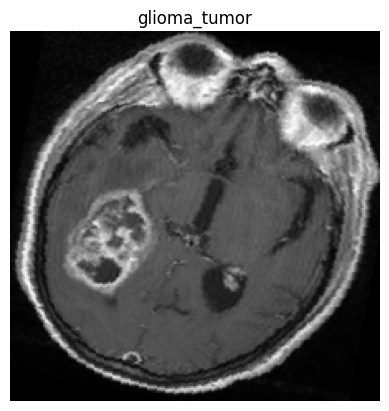

In [5]:
%run /content/Brain-Tumor-Images-Classification/Data-Preprocessing/Brain_tumor_data_preprocessing.ipynb

In [7]:
import torch
import torch.nn as nn
# Define the CNN model in PyTorch
class CNNModel(nn.Module):
    def __init__(self, conv_layers, layer_size, dense_layers):
        super(CNNModel, self).__init__()
        self.conv_layers = conv_layers
        self.layer_size = layer_size
        self.dense_layers = dense_layers

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, layer_size, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

        # Additional convolutional layers
        self.conv2 = nn.Conv2d(layer_size, layer_size, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(layer_size, layer_size, kernel_size=3, padding=1)

        # Calculate the size of the feature map after the convolutional layers
        # Assuming input size of 224x224, and 2x2 pooling after each conv layer
        self.feature_map_size = 224 // (2 ** conv_layers)  # Dividing by 2 for each pooling layer

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(layer_size * self.feature_map_size * self.feature_map_size, dense_layers * 128)  # Adjust size
        self.fc2 = nn.Linear(dense_layers * 128, 4)  # 4 output classes

        # Dropout layer
        self.dropout = nn.Dropout(0.33)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        if self.conv_layers > 1:
            x = self.relu(self.conv2(x))
            x = self.maxpool(x)

        if self.conv_layers > 2:
            x = self.relu(self.conv3(x))
            x = self.maxpool(x)

        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [8]:
import torch.optim as optim
from sklearn.metrics import classification_report

# Function to train the model
def train_model(model, train_loader, val_loader, device, epochs=20):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_preds.double() / total_preds
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss / len(train_loader)
        }
        checkpoint_path = "/content/drive/My Drive/cnn_brain_tumor_checkpoint.pth"
        save_checkpoint(checkpoint, checkpoint_path)

        # Evaluate the model on validation data
        val_acc = evaluate_model(model, val_loader, device)
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model


In [9]:
# Save checkpoint function
def save_checkpoint(checkpoint, checkpoint_path):
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

In [10]:
# Load checkpoint function
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {checkpoint_path}")
    print(f"Resumed from epoch {epoch}, loss: {loss}")
    return model, optimizer, epoch

In [11]:
import torch
import numpy as np
from sklearn.metrics import classification_report

# Function to evaluate the model
def evaluate_model(model, val_loader, device):
    model.eval()
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred))
    return accuracy

In [12]:
from torch.utils.data import DataLoader, random_split

# Assuming the datasets have already been loaded in previous code as 'train_ds' and 'val_ds'
# Otherwise, import or call the datasets here if not already available

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [13]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
conv_layers = 3
layer_size = 64
dense_layers = 2
epochs = 20

# Initialize model
model = CNNModel(conv_layers=conv_layers, layer_size=layer_size, dense_layers=dense_layers)

Using device: cuda


In [14]:
# Train the model
trained_model = train_model(model, train_loader, val_loader, device, epochs)

# Evaluate the model
evaluate_model(trained_model, val_loader, device)


Epoch 1/20 - Loss: 1.1914 - Accuracy: 0.5000
Checkpoint saved to /content/drive/My Drive/cnn_brain_tumor_checkpoint.pth
Validation Accuracy: 0.5712
              precision    recall  f1-score   support

           0       0.67      0.49      0.56       179
           1       0.48      0.62      0.54       191
           2       1.00      0.01      0.02        95
           3       0.60      0.93      0.73       167

    accuracy                           0.57       632
   macro avg       0.69      0.51      0.46       632
weighted avg       0.65      0.57      0.52       632

Epoch 2/20 - Loss: 0.8817 - Accuracy: 0.6221
Checkpoint saved to /content/drive/My Drive/cnn_brain_tumor_checkpoint.pth
Validation Accuracy: 0.6108
              precision    recall  f1-score   support

           0       0.48      0.84      0.61       179
           1       0.66      0.18      0.29       191
           2       0.62      0.74      0.67        95
           3       0.86      0.78      0.82       16

tensor(0.8608, device='cuda:0', dtype=torch.float64)

In [15]:
# Function to test the model
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct_preds = 0
    total_preds = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # No need to calculate gradients during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels.data)
            total_preds += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = correct_preds.double() / total_preds
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print(classification_report(y_true, y_pred))
    return accuracy

# Assuming you already have the test_loader prepared

# Test the model
test_accuracy = test_model(trained_model, test_loader, device)

Test Accuracy: 0.8956
              precision    recall  f1-score   support

           0       0.80      0.89      0.85        83
           1       0.91      0.84      0.87       103
           2       0.86      0.86      0.86        36
           3       0.99      0.97      0.98        94

    accuracy                           0.90       316
   macro avg       0.89      0.89      0.89       316
weighted avg       0.90      0.90      0.90       316



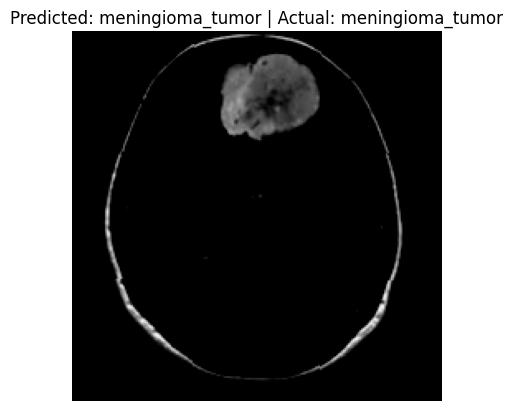

Predicted Label: meningioma_tumor
Actual Label: meningioma_tumor


In [24]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms

def test_random_image(model, test_loader, device, class_names):
    # Set the model to evaluation mode
    model.eval()

    # Get a random sample from the test_loader
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Select a random image and its corresponding label
    idx = random.randint(0, len(images) - 1)
    img = images[idx].unsqueeze(0).to(device)  # Add batch dimension and move to device
    true_label = labels[idx].item()

    # Make prediction
    with torch.no_grad():  # Disable gradient calculation
        output = model(img)
        _, predicted = torch.max(output, 1)

    predicted_label = predicted.item()

    # Convert the image back to a format for display
    img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format

    # Display the image along with predicted and actual labels
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_label]} | Actual: {class_names[true_label]}")
    plt.axis('off')
    plt.show()

    # Print the actual and predicted labels
    print(f"Predicted Label: {class_names[predicted_label]}")
    print(f"Actual Label: {class_names[true_label]}")

# Call the function to test on a random image
test_random_image(trained_model, test_loader, device, class_names)

In [25]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
model, optimizer, epoch = load_checkpoint('/content/drive/My Drive/cnn_brain_tumor_checkpoint.pth')

<ipython-input-10-01abfa35a337>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from /content/drive/My Drive/cnn_brain_tumor_checkpoint.pth
Resumed from epoch 20, loss: 0.1734428786623799
